In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
import warnings
import string
import re
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, roc_curve, classification_report, confusion_matrix, precision_recall_curve, auc

In [31]:
data = pd.read_json('data/Sarcasm_Headlines_Dataset_v2.json', lines=True)
data = data.drop('article_link', axis=1)
assert data.shape == tuple([28619, 2])
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [20]:
def clf_model(model_type, X_train, y_train, X_valid):
    model = model_type.fit(X_train,y_train)
    predicted_labels = model.predict(X_valid)
    predicted_probab = model.predict_proba(X_valid)[:,1]
    assert len(predicted_labels) == len(predicted_probab) == X_valid.shape[0]
    return [predicted_labels,predicted_probab, model]

In [26]:
def model_evaluation(actual_values, predicted_values, predicted_probabilities):
    assert len(actual_values) == len(predicted_values) == len(predicted_probabilities)
    cfn_mat = confusion_matrix(actual_values,predicted_values)
    print("confusion matrix: \n",cfn_mat)
    print("\naccuracy: ",accuracy_score(actual_values,predicted_values))
    print("\nclassification report: \n", classification_report(actual_values,predicted_values))
    fpr,tpr,threshold=roc_curve(actual_values, predicted_probabilities)
    print ('\nArea under ROC curve for validation set:', auc(fpr,tpr))
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(fpr,tpr,label='Validation set AUC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    ax.legend(loc='best')
    plt.show()

In [14]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
stop_words = stop_words + list(string.printable)
data['cleaned_headline_text'] = data['headline'].apply(\
lambda x : ' '.join([lemmatizer.lemmatize(word.lower()) \
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x))) if word.lower() not in stop_words]))

In [29]:
MAX_FEATURES = 200
tfidf_model = TfidfVectorizer(max_features=MAX_FEATURES)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(data['cleaned_headline_text']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
assert (tfidf_df!=0).any().all()
tfidf_df.head()

,000,10,20,actually,america,american,announces,another,anti,area,...,way,week,white,win,without,woman,work,world,would,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.698252,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(tfidf_df, data['is_sarcastic'], test_size=0.2, random_state=42,stratify = data['is_sarcastic'])

confusion matrix: 
 [[2662  335]
 [1775  952]]

accuracy:  0.6313766596785465

classification report: 
               precision    recall  f1-score   support

           0       0.60      0.89      0.72      2997
           1       0.74      0.35      0.47      2727

    accuracy                           0.63      5724
   macro avg       0.67      0.62      0.60      5724
weighted avg       0.67      0.63      0.60      5724


Area under ROC curve for validation set: 0.6762047464895528


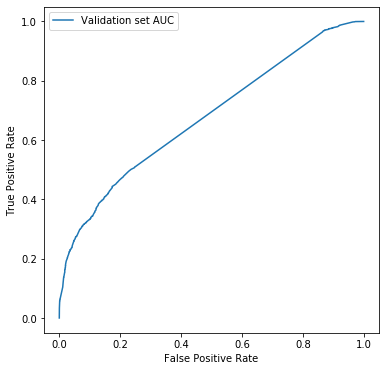

In [24]:
from xgboost import XGBClassifier
xgb_clf=XGBClassifier(n_estimators=10,learning_rate=0.05,max_depth=18,subsample=0.6,colsample_bytree= 0.6,reg_alpha= 10,seed=42)
results = clf_model(xgb_clf, X_train, y_train, X_valid)
model_evaluation(y_valid, results[0], results[1])
model_xgb = results[2]

In [30]:
word_importances = pd.DataFrame({'word':X_train.columns,'importance':model_xgb.feature_importances_})
assert word_importances.shape == tuple([MAX_FEATURES, 2])
word_importances.sort_values('importance', ascending = False).head(4)

,word,importance
113,man,0.206661
182,trump,0.102740
150,report,0.088546
9,area,0.067924
